Missing regions: ['CORSE']


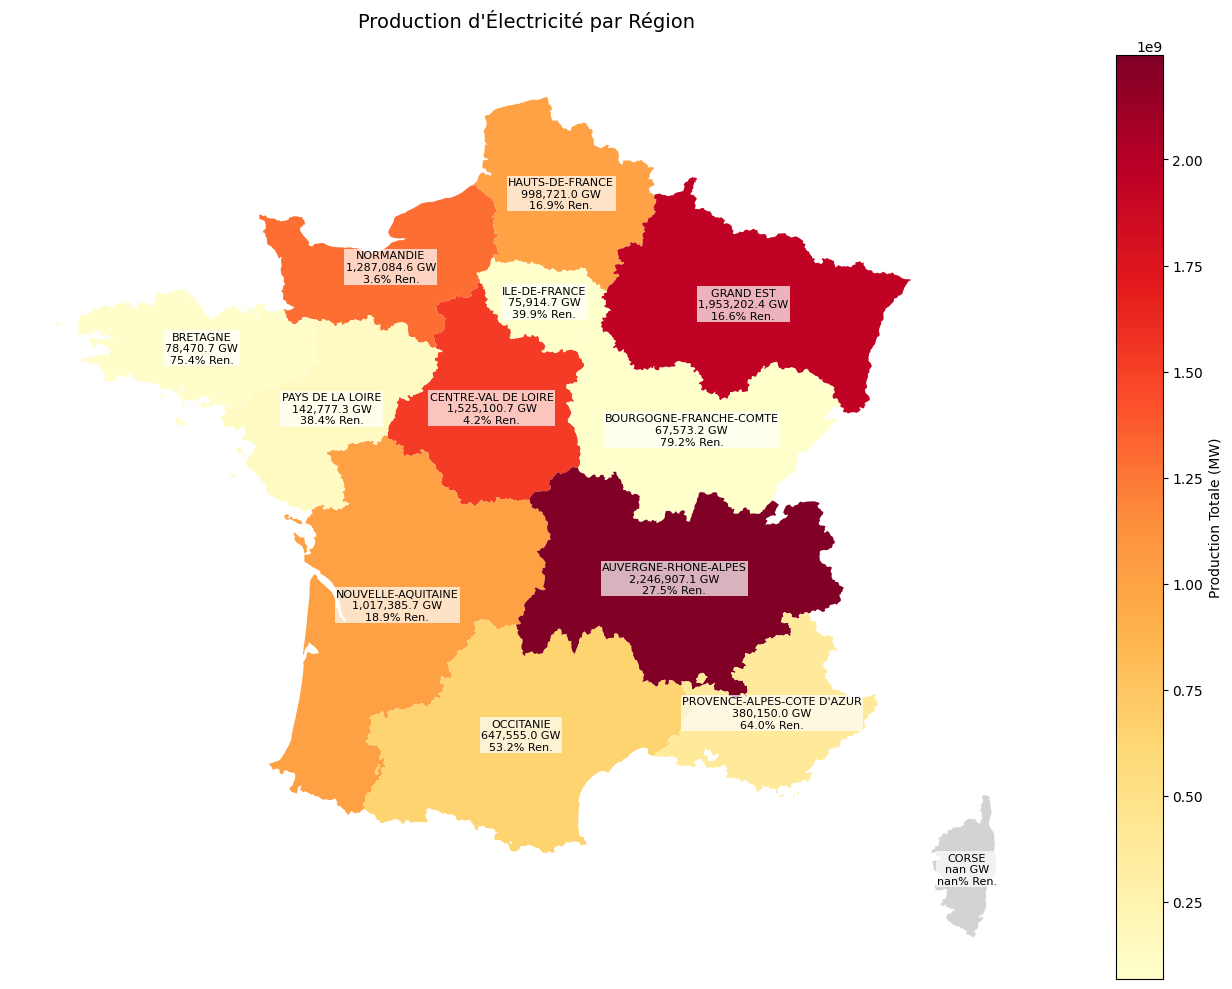

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import tempfile
import os
import pandas as pd
import unidecode

def download_region_geojson():
    url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/regions-version-simplifiee.geojson"
    response = requests.get(url)
    temp_dir = tempfile.gettempdir()
    temp_file = os.path.join(temp_dir, "regions.geojson")
    with open(temp_file, 'wb') as f:
        f.write(response.content)
    return temp_file

def create_energy_production_map():
    # Load energy data
    df = pd.read_csv("/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv", sep=";", low_memory=False)

    # Process energy data
    energy_cols = ['Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)',
                  'Solaire (MW)', 'Hydraulique (MW)', 'Pompage (MW)',
                  'Bioénergies (MW)']

    for col in energy_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Calculate total and renewable production by region
    df['Total (MW)'] = df[energy_cols].sum(axis=1)
    renewable_cols = ['Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)', 'Bioénergies (MW)']
    df['Renouvelable (MW)'] = df[renewable_cols].sum(axis=1)

    # Group by region and calculate the sums
    production_by_region = df.groupby('Région')[['Total (MW)', 'Renouvelable (MW)']].sum()

    # Calculate the renewable percentage
    production_by_region['Pourcentage Renouvelable'] = (
        production_by_region['Renouvelable (MW)'] / production_by_region['Total (MW)'].replace(0, 1) * 100
    )

    # Load geographic data
    regions_file = download_region_geojson()
    regions_gdf = gpd.read_file(regions_file)

    # Normalize region names in regions_gdf
    regions_gdf['nom'] = regions_gdf['nom'].str.upper().apply(lambda x: unidecode.unidecode(x))

    # Normalize region names in production_by_region index
    production_by_region.index = [unidecode.unidecode(x.upper()) for x in production_by_region.index]

    # Merge the DataFrames
    regions_gdf = regions_gdf.merge(production_by_region, left_on='nom', right_index=True, how='left')

    # Check for missing data after merging
    if regions_gdf['Total (MW)'].isna().any():
        print("Warning: Some regions still have missing production data.")
        print("Missing regions:", regions_gdf[regions_gdf['Total (MW)'].isna()]['nom'].values)

    # Create figure
    fig = plt.figure(figsize=(15, 10))
    ax_map = fig.add_subplot(111)

    # Plot choropleth map
    regions_gdf.plot(
        column='Total (MW)',
        ax=ax_map,
        legend=True,
        legend_kwds={'label': 'Production Totale (MW)'},
        cmap='YlOrRd',
        missing_kwds={'color': 'lightgrey'}
    )

    # Add region labels with production info
    for idx, row in regions_gdf.iterrows():
        centroid = row.geometry.centroid
        total_prod = row['Total (MW)']
        renew_pct = row['Pourcentage Renouvelable']

        # Format text to display on the map
        text = f"{row['nom']}\n{total_prod/1000:,.1f} GW\n{renew_pct:.1f}% Ren."

        ax_map.annotate(
            text,
            xy=(centroid.x, centroid.y),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
        )

    # Finalizing map
    ax_map.set_title("Production d'Électricité par Région", fontsize=14, pad=20)
    ax_map.axis('off')  # Hide axis
    plt.tight_layout()

    # Show plot
    plt.show()

# Create and show the map with annotations
create_energy_production_map()

In [ ]:
!pip install unidecode
!pip install requests

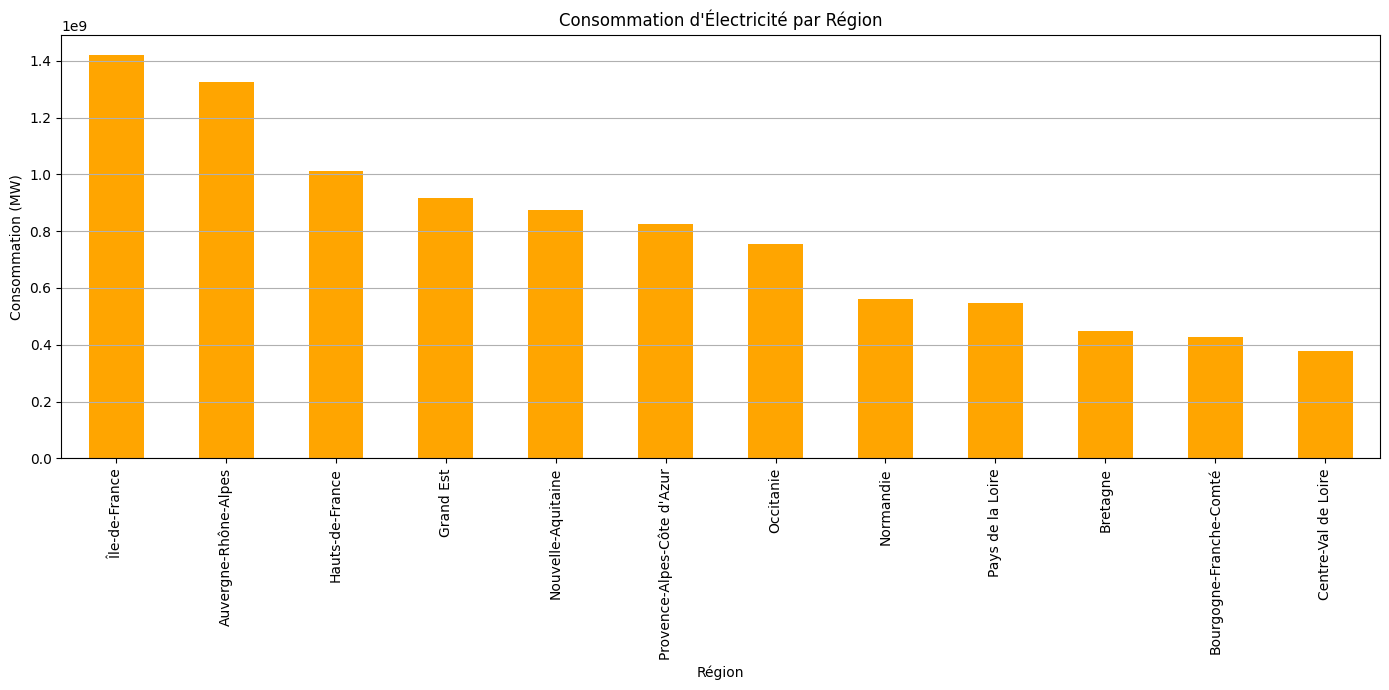

In [ ]:

# Charger le fichier CSV contenant les données, en spécifiant le séparateur et désactivant l'option low_memory
df = pd.read_csv("/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv", sep=";", low_memory=False)

# Remplacer les valeurs manquantes par 0
df['Consommation (MW)'] = df['Consommation (MW)'].fillna(0)
df['Thermique (MW)'] = df['Thermique (MW)'].fillna(0)
df['Nucléaire (MW)'] = df['Nucléaire (MW)'].fillna(0)

# Convertir la colonne de production éolienne en numérique, remplacer les erreurs par NaN puis par
df['Eolien (MW)'] = pd.to_numeric(df['Eolien (MW)'], errors='coerce').fillna(0)
df['Solaire (MW)'] = df['Solaire (MW)'].fillna(0)
df['Hydraulique (MW)'] = df['Hydraulique (MW)'].fillna(0)
df['Pompage (MW)'] = df['Pompage (MW)'].fillna(0)
df['Bioénergies (MW)'] = df['Bioénergies (MW)'].fillna(0)

# Regrouper les données par région et calculer la consommation totale d'électricité pour chaque région
consumption_by_region = df.groupby('Région')['Consommation (MW)'].sum().sort_values(ascending=False)

# Créer une figure pour le graphique avec une taille spécifiée
plt.figure(figsize=(14, 7))

# Tracer un histogramme de la consommation d'électricité par région
consumption_by_region.plot(kind='bar', color='orange')

# Ajouter un titre et des labels aux axes
plt.title('Consommation d\'Électricité par Région')
plt.xlabel('Région')
plt.ylabel('Consommation (MW)')  # 'MW' signifie mégawatts

# Activer la grille pour améliorer la lisibilité du graphique
plt.grid(axis='y')

# Ajuster la mise en page pour éviter les chevauchements de texte
plt.tight_layout()

# Afficher le graphique
plt.show()

# Commentaires du graphe ci-dessous

#Comme nous nous y attendions, la région Ile de France se distingue avec une consommation de 1,4 millard de MW. En Ile de France nous avons Paris la capitale de la FRance,
#ville la plus peuplée du Pays, la plus dense et ainsi que le premier pôle economique.


#Auvergne-Rhône-Alpes arrive en 2eme position suit avec une consommation proche de 1,3 milliard de MW, très légerement en dessous de l’Île-de-France.
#Rappelons que Lyon 2eme ville de France en population et en pôle econimique fait partie de cette région.

#Hauts-de-France arrive en 3eme position avec une consommation proche de 1,2 milliard de MW, ce qui reste significativement élevé.
#Cette région a aussi une forte concentration industrielle et une population importante.


# Les consommation les plus faibles se trouvent en Bretagne, Bourgogne-Franche-Comté et Centre-Val de Loire, toutes en dessous de 400 millions de MW.
#Ces régions, sont très vastes en superficie, mais pas beaucoup denses et avec une activité économique moindre.


#Conclusions et Corrélation. Il semble y avoir un lien direct et fort entre la consommation et
  #- l'activité économique
  #- la densité de la population

#SOURCES UTILISEES POUR L'ANALYSE

#1. Produit intérieur brut (PIB) en France en 2021, selon les régions(en millions d'euros)
#https://fr.statista.com/statistiques/479490/pib-par-habitant-selon-regions-france/

#2  Nombre d'habitants en France au 1er janvier 2024, selon la région
#https://fr.statista.com/statistiques/499848/nombre-habitants-par-region-france/

#3 Densité de population en France en 2021, par région(en nombre d'habitants par kilomètre carré)
#https://fr.statista.com/statistiques/473985/densite-de-population-en-france/


In [ ]:
df.columns

Index(['Code INSEE région', 'Région', 'Nature', 'Date', 'Heure',
       'Date - Heure', 'Consommation (MW)', 'Thermique (MW)', 'Nucléaire (MW)',
       'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)', 'Pompage (MW)',
       'Bioénergies (MW)', 'Ech. physiques (MW)', 'Stockage batterie',
       'Déstockage batterie', 'Eolien terrestre', 'Eolien offshore',
       'TCO Thermique (%)', 'TCH Thermique (%)', 'TCO Nucléaire (%)',
       'TCH Nucléaire (%)', 'TCO Eolien (%)', 'TCH Eolien (%)',
       'TCO Solaire (%)', 'TCH Solaire (%)', 'TCO Hydraulique (%)',
       'TCH Hydraulique (%)', 'TCO Bioénergies (%)', 'TCH Bioénergies (%)',
       'Column 30', 'Production (MW)'],
      dtype='object')

<ipython-input-56-ae02ccf7b93d>:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv", sep=";")


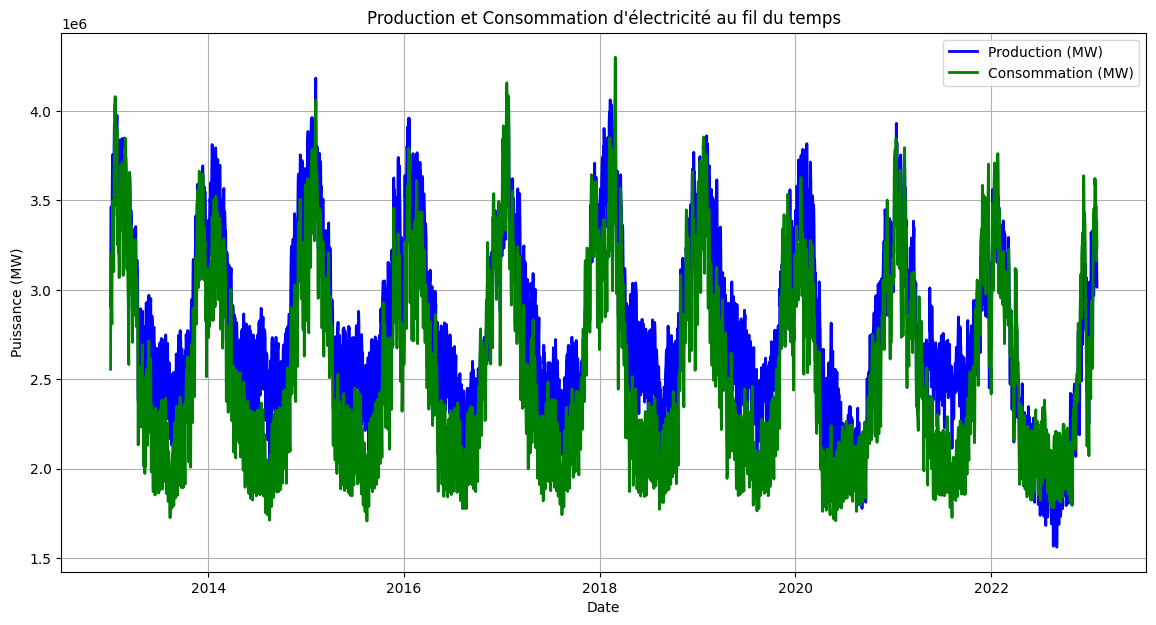

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier CSV contenant les données, en spécifiant le séparateur et désactivant l'option low_memory
df = pd.read_csv("/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv", sep=";")

# Remplacer les valeurs manquantes par 0 pour chaque source d'énergie
df['Consommation (MW)'] = df['Consommation (MW)'].fillna(0)
df["Thermique (MW)"] = df["Thermique (MW)"].fillna(0)
df["Nucléaire (MW)"] = df["Nucléaire (MW)"].fillna(0)
df["Eolien (MW)"] = pd.to_numeric(df["Eolien (MW)"], errors='coerce').fillna(0)
df["Solaire (MW)"] = df["Solaire (MW)"].fillna(0)
df["Hydraulique (MW)"] = df["Hydraulique (MW)"].fillna(0)
df["Pompage (MW)"] = df["Pompage (MW)"].fillna(0)
df["Bioénergies (MW)"] = df["Bioénergies (MW)"].fillna(0)

# Calculer la production totale d'électricité en sommant toutes les sources d'énergie
production_MW = (
    df["Thermique (MW)"] +
    df["Nucléaire (MW)"] +
    df["Eolien (MW)"] +
    df["Solaire (MW)"] +
    df["Hydraulique (MW)"] +
    df["Pompage (MW)"] +
    df["Bioénergies (MW)"]
)

# Ajouter la colonne de production totale au DataFrame
df['Production (MW)'] = production_MW

# Convertir la colonne 'Date' en format datetime pour faciliter le traitement des dates
df['Date'] = pd.to_datetime(df['Date'])

# Regrouper les données par date pour obtenir les totaux quotidiens
totaux_quotidiens = df.groupby('Date').agg({
    'Production (MW)': 'sum',
    'Consommation (MW)': 'sum'
}).reset_index()

# Créer une figure pour le graphique avec une taille spécifiée
plt.figure(figsize=(14, 7))

# Tracer la courbe de production d'électricité au fil du temps
plt.plot(totaux_quotidiens['Date'], totaux_quotidiens['Production (MW)'], label='Production (MW)', color='blue', linewidth=2)

# Tracer la courbe de consommation d'électricité au fil du temps
plt.plot(totaux_quotidiens['Date'], totaux_quotidiens['Consommation (MW)'], label='Consommation (MW)', color='green', linewidth=2)

# Ajouter un titre et des labels aux axes
plt.title('Production et Consommation d\'électricité au fil du temps')
plt.xlabel('Date')
plt.ylabel('Puissance (MW)')  # 'Puissance' est utilisé ici

# Ajouter la légende pour identifier les courbes
plt.legend()

# Activer la grille pour améliorer la lisibilité du graphique
plt.grid()

# Afficher le graphique
plt.show()


<ipython-input-65-ab254f81fd71>:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv", sep=";")
<ipython-input-65-ab254f81fd71>:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  totaux_mensuels = df_covid_reprise.resample('M', on='Date').agg({


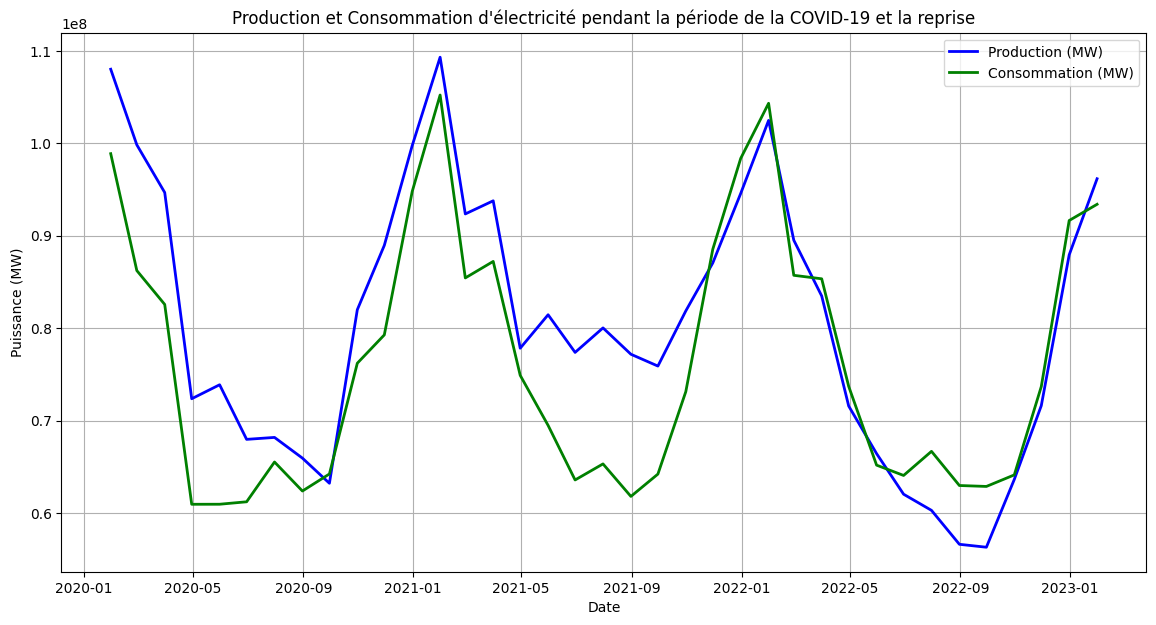

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier CSV contenant les données, en spécifiant le séparateur et désactivant l'option low_memory
df = pd.read_csv("/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv", sep=";")

# Remplacer les valeurs manquantes par 0 pour chaque source d'énergie afin d'éviter les erreurs lors des calculs
df['Consommation (MW)'] = df['Consommation (MW)'].fillna(0)
df["Thermique (MW)"] = df["Thermique (MW)"].fillna(0)
df["Nucléaire (MW)"] = df["Nucléaire (MW)"].fillna(0)

# Convertir les valeurs d'éolien en numérique, en remplaçant les erreurs par 0
df["Eolien (MW)"] = pd.to_numeric(df["Eolien (MW)"], errors='coerce').fillna(0)
df["Solaire (MW)"] = df["Solaire (MW)"].fillna(0)
df["Hydraulique (MW)"] = df["Hydraulique (MW)"].fillna(0)
df["Pompage (MW)"] = df["Pompage (MW)"].fillna(0)
df["Bioénergies (MW)"] = df["Bioénergies (MW)"].fillna(0)

# Calculer la production totale d'électricité en sommant toutes les sources d'énergie
production_MW = (
    df["Thermique (MW)"] +
    df["Nucléaire (MW)"] +
    df["Eolien (MW)"] +
    df["Solaire (MW)"] +
    df["Hydraulique (MW)"] +
    df["Pompage (MW)"] +
    df["Bioénergies (MW)"]
)

# Ajouter la colonne de production totale au DataFrame pour une utilisation ultérieure
df['Production (MW)'] = production_MW

# Convertir la colonne 'Date' en format datetime pour faciliter le traitement des dates et l'indexation
df['Date'] = pd.to_datetime(df['Date'])

# Filtrer les données pour ne garder que la période de la COVID-19 et la reprise
# Exemple : du début de 2020 à la fin de 2023
date_debut = '2020-01-01'  # Date de début de la période d'analyse
date_fin = '2023-12-31'    # Date de fin de la période d'analyse
df_covid_reprise = df[(df['Date'] >= date_debut) & (df['Date'] <= date_fin)]

# Regrouper les données par mois pour obtenir les totaux mensuels
totaux_mensuels = df_covid_reprise.resample('M', on='Date').agg({
    'Production (MW)': 'sum',  # Somme de la production par mois
    'Consommation (MW)': 'sum'  # Somme de la consommation par mois
}).reset_index()  # Réinitialiser l'index pour avoir un DataFrame propre

# Créer une figure pour le graphique avec une taille spécifiée
plt.figure(figsize=(14, 7))

# Tracer la courbe de production d'électricité par mois
plt.plot(totaux_mensuels['Date'], totaux_mensuels['Production (MW)'], label='Production (MW)', color='blue', linewidth=2)

# Tracer la courbe de consommation d'électricité par mois
plt.plot(totaux_mensuels['Date'], totaux_mensuels['Consommation (MW)'], label='Consommation (MW)', color='green', linewidth=2)

# Ajouter un titre et des labels aux axes pour clarifier le contenu du graphique
plt.title('Production et Consommation d\'électricité pendant la période de la COVID-19 et la reprise')
plt.xlabel('Date')  # Label pour l'axe des abscisses
plt.ylabel('Puissance (MW)')  # Label pour l'axe des ordonnées

# Ajouter la légende pour identifier les courbes sur le graphique
plt.legend()

# Activer la grille pour améliorer la lisibilité du graphique
plt.grid()

# Afficher le graphique final
plt.show()


<ipython-input-62-0094e7188a65>:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv", sep=";")
<ipython-input-62-0094e7188a65>:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  totaux_bimensuels = totaux_quotidiens.set_index('Date').resample('2M').sum().reset_index()


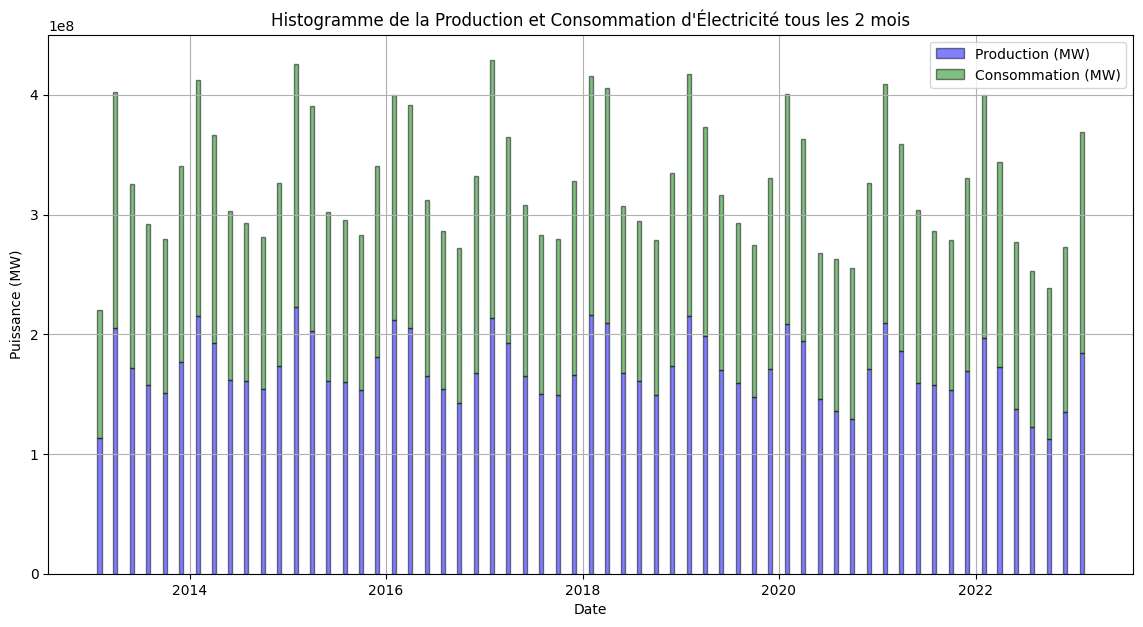

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier CSV contenant les données en spécifiant le séparateur
df = pd.read_csv("/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv", sep=";")

# Remplacer les valeurs manquantes par 0 pour chaque source d'énergie
df['Consommation (MW)'] = df['Consommation (MW)'].fillna(0)
df["Thermique (MW)"] = df["Thermique (MW)"].fillna(0)
df["Nucléaire (MW)"] = df["Nucléaire (MW)"].fillna(0)
df["Eolien (MW)"] = pd.to_numeric(df["Eolien (MW)"], errors='coerce').fillna(0)  # Conversion en numérique
df["Solaire (MW)"] = df["Solaire (MW)"].fillna(0)
df["Hydraulique (MW)"] = df["Hydraulique (MW)"].fillna(0)
df["Pompage (MW)"] = df["Pompage (MW)"].fillna(0)
df["Bioénergies (MW)"] = df["Bioénergies (MW)"].fillna(0)

# Calculer la production totale d'électricité en sommant toutes les sources d'énergie
production_MW = (
    df["Thermique (MW)"] +
    df["Nucléaire (MW)"] +
    df["Eolien (MW)"] +
    df["Solaire (MW)"] +
    df["Hydraulique (MW)"] +
    df["Pompage (MW)"] +
    df["Bioénergies (MW)"]
)

# Ajouter la colonne de production totale au DataFrame
df['Production (MW)'] = production_MW

# Convertir la colonne 'Date' en format datetime pour faciliter le traitement des dates
df['Date'] = pd.to_datetime(df['Date'])

# Regrouper les données par date pour obtenir les totaux quotidiens
totaux_quotidiens = df.groupby('Date').agg({
    'Production (MW)': 'sum',
    'Consommation (MW)': 'sum'
}).reset_index()

# Regrouper les totaux par période de deux mois
totaux_bimensuels = totaux_quotidiens.set_index('Date').resample('2M').sum().reset_index()

# Créer une figure pour les histogrammes avec une taille spécifiée
plt.figure(figsize=(14, 7))

# Tracer l'histogramme pour la production d'électricité
plt.bar(totaux_bimensuels['Date'], totaux_bimensuels['Production (MW)'],
        width=15, alpha=0.5, label='Production (MW)', color='blue', edgecolor='black')

# Tracer l'histogramme pour la consommation d'électricité
plt.bar(totaux_bimensuels['Date'], totaux_bimensuels['Consommation (MW)'],
        width=15, alpha=0.5, label='Consommation (MW)', color='green', edgecolor='black', bottom=totaux_bimensuels['Production (MW)'])

# Ajouter un titre et des labels aux axes
plt.title('C')
plt.xlabel('Date')
plt.ylabel('Puissance (MW)')

# Ajouter la légende pour identifier les histogrammes
plt.legend()

# Activer la grille pour améliorer la lisibilité du graphique
plt.grid()

# Afficher le graphique
plt.show()
